In [20]:
using LinearAlgebra, SparseArrays, IterativeSolvers,Plots

In [4]:
function VorticityBoundaryConditions!(ω, ψ, Δx, Δy, un, us, ve, vw)
ω[:, end] .= 2 * ((ψ[:, end] - ψ[:, end-1]) / (Δx ^ 2) .- ve / Δx)
ω[:, 1] .= 2 * ((ψ[:, 1] - ψ[:, 2]) / (Δx ^ 2) .- vw / Δx)
ω[end, :] .= 2 * ((ψ[end, :] - ψ[end-1, :]) / (Δy ^ 2) .+ us / Δy)
ω[1, :] .= 2 * ((ψ[1, :] - ψ[2, :]) / (Δy ^ 2) .+ un / Δy)
end

VorticityBoundaryConditions! (generic function with 1 method)

In [21]:
function GaussSiedel!(ϕ, Ap, An, As, Ae, Aw, Rp, res; λ=1, maxiter=1000)
  normRes = 1
  k = 0
  Ny, Nx = size(ϕ)
  while normRes >= 1e-8 && k < maxiter
    k += 1
    for i in 2:Ny-1
      for j in 2:Nx-1
        ϕP = ϕ[i, j]
        ϕE = ϕ[i+0, j+1]
        ϕW = ϕ[i+0, j-1]
        ϕN = ϕ[i-1, j+0]
        ϕS = ϕ[i+1, j+0]
        res[i, j] = Rp[i, j] - (Ap * ϕP+ An * ϕN+ As * ϕS+ Ae * ϕE+ Aw * ϕW)
        Δϕ = res[i, j] / Ap
        ϕ[i, j] = λ * (ϕ[i, j] + Δϕ) + (1 - λ) * ϕ[i, j]
      end
    end
    normRes = norm(res)
  end
  return k
end

GaussSiedel! (generic function with 1 method)

In [22]:
function LinearSolve!(A, x, b)
  # Solves the equation Ax = b assuming zero Dirichlet BCs everywhere
  Ny, Nx = size(b)
  Ny, Nx = Ny - 2, Nx - 2
  x_int = x[2:end-1, 2:end-1]
  b_int = b[2:end-1, 2:end-1]
  b_vec = reshape(b_int, Ny * Nx)
  # x_int = A\b_vec
  x_vec = reshape(x_int, Ny * Nx)
  cg!(x_vec, A, b_vec, log=true)
  x[2:end-1, 2:end-1] .= reshape(x_int, (Ny, Nx))
end

LinearSolve! (generic function with 1 method)

In [23]:
function BuildPoissonMatrix(Ny, Nx, Δx, Δy)
  # This function returns a (Ny*Nx) × (Ny*Nx) matrix in the form of
  # a sparse array, corresponding to the discrete 2D Laplacian operator.
  Ny = Ny - 2
  Nx = Nx - 2

  Isx = [1:Ny; 1:Ny-1; 2:Ny]
  Jsx = [1:Ny; 2:Ny; 1:Ny-1]

  Isy = [1:Nx; 1:Nx-1; 2:Nx]
  Jsy = [1:Nx; 2:Nx; 1:Nx-1]

  Vsx = [fill(-2, Ny); fill(1, 2Ny - 2)]
  Vsy = [fill(-2, Nx); fill(1, 2Nx - 2)]
  D²x = sparse(Isx, Jsx, Vsx)
  D²y = sparse(Isy, Jsy, Vsy)
  D_yy = 1 / (Δy^2) .* kron(sparse(I, Nx, Nx), D²x)
  D_xx = 1 / (Δx^2) .* kron(D²y, sparse(I, Ny, Ny))
  Lap = D_xx + D_yy
end

BuildPoissonMatrix (generic function with 1 method)

In [24]:
function BuildAdvectionDiffusionCoefficients(Re, Δt, Δx, Δy)
  # Time-derivative
  ap = 1 / Δt
  # Diffusion
  ap += 2 / (Re * Δx^2) + 2 / (Re * Δy^2)
  an = -1 / (Re * Δy^2)
  aw = -1 / (Re * Δx^2)
  as = -1 / (Re * Δy^2)
  ae = -1 / (Re * Δx^2)
  return ap, an, as, ae, aw
end

BuildAdvectionDiffusionCoefficients (generic function with 1 method)

In [25]:
function BuildAdvectionDiffusionRHS!(Rp, ϕ, ψ, Δt, Δx, Δy, Ny, Nx, Re)
  # Time derivative
  Rp .= ϕ / Δt

  # Diffusion term (fully implicit)

  # Convection term
  for i in 2:Ny-1
    for j in 2:Nx-1
      ϕE = ϕ[i+0, j+1]
      ϕW = ϕ[i+0, j-1]
      ϕN = ϕ[i-1, j+0]
      ϕS = ϕ[i+1, j+0]
      ψE = ψ[i+0, j+1]
      ψW = ψ[i+0, j-1]
      ψN = ψ[i-1, j+0]
      ψS = ψ[i+1, j+0]

      u = (ψN - ψS) / (2Δy)
      v = -(ψE - ψW) / (2Δx)
      ∂ϕ∂y = (ϕN - ϕS) / (2Δy)
      ∂ϕ∂x = (ϕE - ϕW) / (2Δx)

      Rp[i, j] += -(u * ∂ϕ∂x + v * ∂ϕ∂y)
    end
  end
end

BuildAdvectionDiffusionRHS! (generic function with 1 method)

In [26]:
function RecordHistory!(ϕ, ϕ_old, ϕ_hist)
  Δϕ = norm(ϕ - ϕ_old)
  ϕ_old .= ϕ
  push!(ϕ_hist, Δϕ)
  return (Δϕ)
end

RecordHistory! (generic function with 1 method)

In [27]:
struct Results
  ψ::Array
  ω::Array
  hist::Array
  x::Array
  y::Array
  tfinal
  steps
  Re
end

In [28]:
ShowStreamlines(sol::Results) = contour(sol.x, sol.y, reverse(reverse(sol.ψ, dims=1), dims=2),
  aspectratio=1, framestyle=:box,
  xlims=(sol.x[1], sol.x[end]),
  ylims=(sol.y[1], sol.y[end]),
  legend=:none, grid=:none)

ShowStreamlines (generic function with 1 method)

In [33]:
function LidDrivenCavity(;
  tfinal=Inf,
  Lx=1, Ly=1, CFL=0.5, Re=100,
  Nx=65, Ny=65,
  u_n=1, u_s=0, v_w=0, v_e=0,
  printfreq=10)
  t0 = time() # begin timing
  println("------------------Ny = $(Ny), Nx = $(Nx) ---------------")
  Δy = Ly / (Ny - 1)
  Δx = Lx / (Nx - 1)
  x = 0:Δx:Lx
  y = 0:Δy:Ly
  Δt = CFL * Δx
  a = Animation()

  # Construct matrix for Poisson equation
  A_poisson = BuildPoissonMatrix(Ny, Nx, Δx, Δy) # for coNxgrad
  # Construct matrix for advection-diffusion equation
  ap, an, as, ae, aw = BuildAdvectionDiffusionCoefficients(Re, Δt, Δx, Δy)
  # allocate empty matrices for Gauss-Siedel solver
  Rp = zeros(Ny, Nx)
  res = zeros(Ny, Nx)

  # initialize ω and ψ
  ω = zeros(Ny, Nx)
  ψ = zeros(Ny, Nx)

  # keep track of changes 
  ω_old = zeros(Ny, Nx)
  ψ_old = zeros(Ny, Nx)
  ω_hist = []
  ψ_hist = []
  residual = 1

  ######### Begin time-stepping #########
  k0, t = 0, 0
  @gif while t < tfinal && maximum(residual) > 1e-8
    t += Δt
    k0 += 1

    # Solve Poisson equation for ψ:
    LinearSolve!(A_poisson, ψ, -ω)

    # Determine boundary conditions on ω using Thom's formula
    VorticityBoundaryConditions!(ω, ψ, Δx, Δy, u_n, u_s, v_e, v_w)

    # Modify the explicit part of advection-diffusion equation
    BuildAdvectionDiffusionRHS!(Rp, ω, ψ, Δt, Δx, Δy, Ny, Nx, Re)

    # Solve advection-diffusion equation for ω:
    GaussSiedel!(ω, ap, an, as, ae, aw, Rp, res)

    # Record changes
    residual = RecordHistory!.([ω, ψ], [ω_old, ψ_old], [ω_hist, ψ_hist])

    # Print to terminal
    if (k0 % printfreq == 0)
      println("Step: $k0 \t Time: $(round(t,digits=3))\t",
        "|Δω|: $(round((residual[1]),digits=8)) \t",
        "|Δψ|: $(round((residual[2]),digits=8)) \t")
        R=Results(ψ, ω, hcat(ω_hist, ψ_hist), x, y, t, k0, Re)
        ShowStreamlines(R)
        frame(a,ShowStreamlines(R))
    end
    
  end
  tt = round(time() - t0, digits=3) # end timing
  println("This took $tt seconds.")
  println("--------------------------------------------------------")
  # Create a struct containing the results
  gif(a)
end

LidDrivenCavity (generic function with 1 method)

------------------Ny = 65, Nx = 65 ---------------
Step: 10 	 Time: 0.078	|Δω|: 11.89838071 	|Δψ|: 0.03342217 	
Step: 20 	 Time: 0.156	|Δω|: 4.49109862 	|Δψ|: 0.02111681 	
Step: 30 	 Time: 0.234	|Δω|: 2.58182282 	|Δψ|: 0.01601195 	
Step: 40 	 Time: 0.312	|Δω|: 1.75155862 	|Δψ|: 0.0130576 	
Step: 50 	 Time: 0.391	|Δω|: 1.29944142 	|Δψ|: 0.01108306 	
Step: 60 	 Time: 0.469	|Δω|: 1.01956028 	|Δψ|: 0.00965119 	
Step: 70 	 Time: 0.547	|Δω|: 0.83116222 	|Δψ|: 0.00855639 	
Step: 80 	 Time: 0.625	|Δω|: 0.69658373 	|Δψ|: 0.0076875 	
Step: 90 	 Time: 0.703	|Δω|: 0.59607835 	|Δψ|: 0.00697838 	
Step: 100 	 Time: 0.781	|Δω|: 0.51837755 	|Δψ|: 0.00638697 	
Step: 110 	 Time: 0.859	|Δω|: 0.45662228 	|Δψ|: 0.00588506 	
Step: 120 	 Time: 0.938	|Δω|: 0.40641946 	|Δψ|: 0.00545296 	
Step: 130 	 Time: 1.016	|Δω|: 0.36483673 	|Δψ|: 0.00507648 	
Step: 140 	 Time: 1.094	|Δω|: 0.32984852 	|Δψ|: 0.00474511 	
Step: 150 	 Time: 1.172	|Δω|: 0.30001451 	|Δψ|: 0.00445089 	
Step: 160 	 Time: 1.25	|Δω|: 0.27428474 	|Δψ

┌ Info: Saved animation to 
│   fn = /Users/io/Project/Finite Element/tmp.gif
└ @ Plots /Users/io/.julia/packages/Plots/YAlrZ/src/animation.jl:114
┌ Info: Saved animation to 
│   fn = /Users/io/Project/Finite Element/tmp.gif
└ @ Plots /Users/io/.julia/packages/Plots/YAlrZ/src/animation.jl:114


Plots.AnimatedGif("/Users/io/Project/Finite Element/tmp.gif")
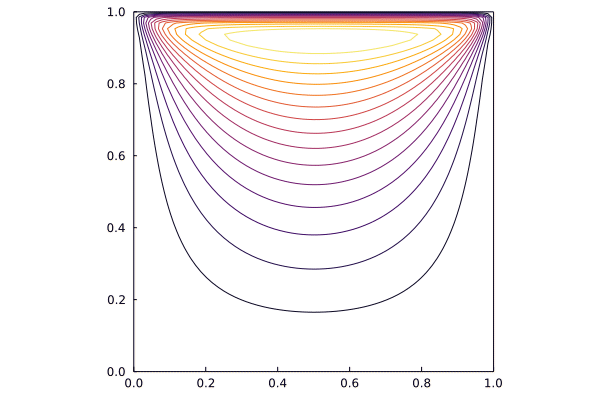

In [34]:
LidDrivenCavity()